# End-to-End Methodology Classifier (Clean, Reproducible)
Includes: data loading, cleaning, stratified split, baselines, NB/LR/Calibrated SVM, CV, tuning, PR/ROC, calibration, error analysis, coverage-accuracy, learning curve, bootstrap CI, nested CV, and artifact saving.

# Cell 1 — Setup: imports, seeds, paths, utils

In [1]:
import os, sys, re, json, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

print("Python :", sys.version.split()[0])
print("numpy  :", np.__version__)
print("pandas :", pd.__version__)

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Paths
PROJECT_ROOT = Path(".")
RES_DIR = PROJECT_ROOT / "results"
FIG_DIR = PROJECT_ROOT / "figs"
for d in (RES_DIR, FIG_DIR):
    d.mkdir(parents=True, exist_ok=True)

# (Optional) Consistent plotting defaults
plt.rcParams.update({
    "figure.dpi": 100,
    "savefig.bbox": "tight",
    "axes.grid": False,
})

def save_fig(name: str, folder: Path = FIG_DIR, dpi: int = 300):
    folder.mkdir(parents=True, exist_ok=True)
    png = folder / f"{name}.png"
    svg = folder / f"{name}.svg"
    plt.savefig(png, dpi=dpi, bbox_inches="tight")
    plt.savefig(svg, bbox_inches="tight")
    print(f"[saved] {png}\n[saved] {svg}")


Python : 3.11.5
numpy  : 1.24.3
pandas : 2.0.3


# Cell 2 — Load data (auto-detect text/label columns)

In [2]:
CSV_PATH = "abstracts_methodology_expanded.csv"  

TEXT_CANDIDATES  = ("cleaned_abstract", "abstract", "Abstract", "text", "Text")
LABEL_CANDIDATES = ("methodology", "Methodology", "label", "Label", "target")

def load_data(csv_path: str):
    p = Path(csv_path)
    if not p.exists():
        raise FileNotFoundError(f"CSV not found: {p.resolve()}")
    df = pd.read_csv(p)
    text_col  = next((c for c in TEXT_CANDIDATES  if c in df.columns), None)
    label_col = next((c for c in LABEL_CANDIDATES if c in df.columns), None)
    if not text_col or not label_col:
        have = list(df.columns)
        raise ValueError(
            f"Could not find columns.\nHave: {have}\n"
            f"Tried text: {TEXT_CANDIDATES}\n"
            f"Tried label: {LABEL_CANDIDATES}"
    )
    df = df.dropna(subset=[text_col, label_col]).copy()
    df[label_col] = df[label_col].astype(str).str.strip()
    return df, text_col, label_col

df, TEXT_COL, LABEL_COL = load_data(CSV_PATH)
print("Detected -> TEXT_COL:", TEXT_COL, "| LABEL_COL:", LABEL_COL)
df[[TEXT_COL, LABEL_COL]].head()


Detected -> TEXT_COL: abstract | LABEL_COL: methodology


,abstract,methodology
0,We report a randomized controlled experiment e...,experiment
1,This study investigates the effect of notifica...,experiment
2,We conducted a counterbalanced within-subjects...,experiment
3,We evaluated an online anomaly detection model...,experiment
4,We ran a controlled experiment to quantify the...,experiment


# Cell 3 — Quick EDA

In [3]:
print("Label counts\n", df[LABEL_COL].value_counts(), "\n")
df["__len__"] = df[TEXT_COL].astype(str).str.split().apply(len)
print("Text length — mean:", df["__len__"].mean(), "| median:", df["__len__"].median())
df["__len__"].describe()

# Add at end of the cell
plt.figure(figsize=(4.2,3.2))
df[LABEL_COL].value_counts().plot(kind="bar")
plt.ylabel("Count"); plt.title("Label distribution")
save_fig("eda_label_distribution"); plt.close()

plt.figure(figsize=(4.2,3.2))
df["__len__"].plot(kind="hist", bins=20)
plt.xlabel("Tokens per abstract"); plt.title("Text length distribution")
save_fig("eda_text_length_hist"); plt.close()


Label counts
 methodology
experiment      50
survey          50
case study      50
design-based    50
Name: count, dtype: int64 

Text length — mean: 25.365 | median: 24.0
[saved] figs/eda_label_distribution.png
[saved] figs/eda_label_distribution.svg
[saved] figs/eda_text_length_hist.png
[saved] figs/eda_text_length_hist.svg


# Cell 4 — Optional cleaning

In [4]:
USE_TEXT_CLEAN = True
CLEAN_COL = "clean_text"

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

if USE_TEXT_CLEAN:
    df[CLEAN_COL] = df[TEXT_COL].astype(str).apply(clean_text)
    ACTIVE_TEXT_COL = CLEAN_COL
else:
    ACTIVE_TEXT_COL = TEXT_COL

print("Using text column:", ACTIVE_TEXT_COL)


Using text column: clean_text


# Cell 5 — Stratified split

In [5]:
# --- toggles ---
DO_SAVE_LATEX    = True   # set False if you don't need a .tex table
DO_SAVE_MARKDOWN = True   # set False if you don't need a .md table

# --- imports ---
from pathlib import Path
from collections import Counter
import json
import numpy as np
import pandas as pd
from IPython.display import display

# --- paths & globals ---
RES_DIR = globals().get('RES_DIR', Path("results"))
RES_DIR.mkdir(parents=True, exist_ok=True)
ART_SPLIT = RES_DIR / "split_indices.json"
ART_META  = RES_DIR / "meta.json"

# --- sanity on data frame & columns ---
assert 'df' in globals(), "DataFrame 'df' not found; run your data-loading cell first."
# Prefer ACTIVE_TEXT_COL if set; otherwise fall back to TEXT_COL
if 'ACTIVE_TEXT_COL' not in globals():
    assert 'TEXT_COL' in globals(), "Neither ACTIVE_TEXT_COL nor TEXT_COL is defined."
    ACTIVE_TEXT_COL = TEXT_COL
assert 'LABEL_COL' in globals(), "LABEL_COL not defined; run your setup cell."
RANDOM_STATE = int(globals().get('RANDOM_STATE', 42))

# --- create a stratified split iff missing or invalid ---
need_split = (not ART_SPLIT.exists()) or (not ART_META.exists()) or \
             any(v not in globals() for v in ["X_train_text","X_test_text","y_train","y_test"])

if need_split:
    from sklearn.model_selection import train_test_split
    X_text = df[ACTIVE_TEXT_COL].astype(str)
    y      = df[LABEL_COL].astype(str)

    # make sure we can stratify (at least 2 per class)
    counts = Counter(y)
    assert min(counts.values()) >= 2, f"Need >=2 items per class to stratify; got {counts}"

    X_train_text, X_test_text, y_train, y_test = train_test_split(
        X_text, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
    )
    print(f"[info] Created 80/20 split with RANDOM_STATE={RANDOM_STATE}.")

    # compute label_order
    label_order = sorted(pd.Index(y_train).append(pd.Index(y_test)).astype(str).unique().tolist())

    # write indices + meta
    split_payload = {"train_index": X_train_text.index.to_list(),
                     "test_index":  X_test_text.index.to_list()}
    ART_SPLIT.write_text(json.dumps(split_payload, indent=2))

    meta_payload = {
        "random_state": RANDOM_STATE,
        "text_col": str(globals().get('TEXT_COL', ACTIVE_TEXT_COL)),
        "active_text_col": str(ACTIVE_TEXT_COL),
        "label_col": str(LABEL_COL),
        "labels": label_order
    }
    ART_META.write_text(json.dumps(meta_payload, indent=2))
    print(f"[saved] {ART_SPLIT}\n[saved] {ART_META}")

# --- load persisted split + meta (source of truth) ---
split = json.loads(ART_SPLIT.read_text())
meta  = json.loads(ART_META.read_text())

idx_tr = split["train_index"]; idx_te = split["test_index"]
y_train = df.loc[idx_tr, meta["label_col"]].astype(str)
y_test  = df.loc[idx_te,  meta["label_col"]].astype(str)

# stable label order
labels = meta.get("labels") or sorted(pd.Index(y_train).append(pd.Index(y_test)).astype(str).unique().tolist())

# --- build counts & proportions ---
train_counts = y_train.value_counts().reindex(labels).fillna(0).astype(int)
test_counts  = y_test.value_counts().reindex(labels).fillna(0).astype(int)
train_pct = (train_counts / max(1, train_counts.sum()))
test_pct  = (test_counts  / max(1, test_counts.sum()))
delta_pct = (test_pct - train_pct)  # test minus train

# raw (machine-readable) table
tbl = pd.DataFrame({
    "Train n": train_counts,
    "Train %": train_pct,
    "Test n":  test_counts,
    "Test %":  test_pct,
    "Δ% (Test−Train)": delta_pct
})

# display-friendly (percent strings) + totals row
tbl_disp = tbl.copy()
for col in ["Train %","Test %","Δ% (Test−Train)"]:
    tbl_disp[col] = (tbl_disp[col] * 100).round(1).map("{:.1f}%".format)

totals = pd.Series({
    "Train n": int(train_counts.sum()),
    "Train %": "100.0%",
    "Test n":  int(test_counts.sum()),
    "Test %":  "100.0%",
    "Δ% (Test−Train)": "—"
}, name="TOTAL")

tbl_disp = pd.concat([tbl_disp, totals.to_frame().T])

# --- show in notebook ---
display(tbl_disp.style.set_caption("Table 5.1 — Stratified split summary (persisted indices)"))

# --- save CSV (raw fractions for % columns) ---
csv_path = RES_DIR / "table_5_1_split_summary.csv"
tbl.to_csv(csv_path, index=True)
print("[saved]", csv_path)

# --- optional: LaTeX table ---
if DO_SAVE_LATEX:
    tex_path = RES_DIR / "table_5_1_split_summary.tex"
    with open(tex_path, "w") as f:
        f.write(tbl.round(3).to_latex(
            index=True,
            caption="Table 5.1 — Stratified split summary (persisted indices)",
            label="tab:split-summary",
            column_format="lrrrrr",
            escape=False
        ))
    print("[saved]", tex_path)

# --- optional: Markdown table ---
if DO_SAVE_MARKDOWN:
    md_path = RES_DIR / "table_5_1_split_summary.md"
    md_lines = [
        "| Label | Train n | Train % | Test n | Test % | Δ% (Test−Train) |",
        "|:------|--------:|--------:|-------:|-------:|----------------:|"
    ]
    for label, row in tbl_disp.iloc[:-1].iterrows():  # skip TOTAL
        md_lines.append(
            f"| {label} | {row['Train n']} | {row['Train %']} | {row['Test n']} | {row['Test %']} | {row['Δ% (Test−Train)']} |"
        )
    t = tbl_disp.iloc[-1]
    md_lines.append(
        f"| **TOTAL** | **{t['Train n']}** | **{t['Train %']}** | **{t['Test n']}** | **{t['Test %']}** | **{t['Δ% (Test−Train)']}** |"
    )
    md_path.write_text("\n".join(md_lines))
    print("[saved]", md_path)

# --- final sanity checks ---
assert set(labels) == set(train_counts.index) == set(test_counts.index), "Label set mismatch."
assert len(idx_tr) == len(y_train) and len(idx_te) == len(y_test), "Index length mismatch."
print("Sanity checks: OK ")

[info] Created 80/20 split with RANDOM_STATE=42.
[saved] results/split_indices.json
[saved] results/meta.json


,Train n,Train %,Test n,Test %,Δ% (Test−Train)
case study,40,25.0%,10,25.0%,0.0%
design-based,40,25.0%,10,25.0%,0.0%
experiment,40,25.0%,10,25.0%,0.0%
survey,40,25.0%,10,25.0%,0.0%
TOTAL,160,100.0%,40,100.0%,—


[saved] results/table_5_1_split_summary.csv
[saved] results/table_5_1_split_summary.tex
[saved] results/table_5_1_split_summary.md
Sanity checks: OK 


# Cell 6 — Pipeline builders

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from inspect import signature

def build_nb(max_features=20000, min_df=2):
    return Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=max_features, min_df=min_df,
                                  strip_accents="unicode", lowercase=True)),
        ("model", MultinomialNB())
    ])

def build_lr(max_features=20000, min_df=2):
    return Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=max_features, min_df=min_df,
                                  strip_accents="unicode", lowercase=True)),
        ("model", LogisticRegression(solver="liblinear", multi_class="ovr",
                                     class_weight="balanced", C=1.0, max_iter=2000,
                                     random_state=RANDOM_STATE))
    ])

def build_svm_calibrated(max_features=20000, min_df=2):
    base = LinearSVC(class_weight="balanced", random_state=RANDOM_STATE)
    if "estimator" in signature(CalibratedClassifierCV).parameters:
        calibrated = CalibratedClassifierCV(estimator=base, method="sigmoid", cv=5)
    else:
        calibrated = CalibratedClassifierCV(base_estimator=base, method="sigmoid", cv=5)
    return Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=max_features, min_df=min_df,
                                  strip_accents="unicode", lowercase=True)),
        ("model", calibrated)
    ])


# Cell 7 — Train & evaluate NB (hold-out)

Naive Bayes — Classification Report
              precision    recall  f1-score   support

  case study       1.00      1.00      1.00        10
design-based       1.00      1.00      1.00        10
  experiment       1.00      1.00      1.00        10
      survey       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



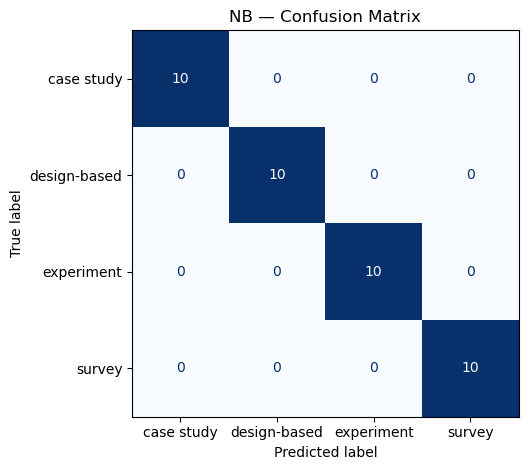

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

nb_pipe = build_nb()
nb_pipe.fit(X_train_text, y_train)
y_nb = nb_pipe.predict(X_test_text)

print("Naive Bayes — Classification Report")
print(classification_report(y_test, y_nb, labels=label_order, zero_division=0))
cm = confusion_matrix(y_test, y_nb, labels=label_order)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
fig, ax = plt.subplots(); disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
ax.set_title("NB — Confusion Matrix"); plt.tight_layout(); plt.show()


# Cell 8 — Train & evaluate Logistic Regression (hold-out)

Logistic Regression — Classification Report
              precision    recall  f1-score   support

  case study       1.00      1.00      1.00        10
design-based       1.00      1.00      1.00        10
  experiment       1.00      1.00      1.00        10
      survey       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



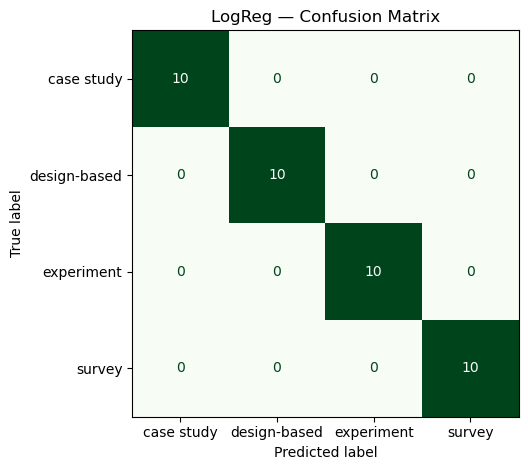

In [8]:
logreg_pipe = build_lr()
logreg_pipe.fit(X_train_text, y_train)
y_lr = logreg_pipe.predict(X_test_text)

print("Logistic Regression — Classification Report")
print(classification_report(y_test, y_lr, labels=label_order, zero_division=0))
cm = confusion_matrix(y_test, y_lr, labels=label_order)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
fig, ax = plt.subplots(); disp.plot(ax=ax, cmap="Greens", values_format="d", colorbar=False)
ax.set_title("LogReg — Confusion Matrix"); plt.tight_layout(); plt.show()


# Cell 9 — Train & evaluate Linear SVM (calibrated) (hold-out)

Linear SVM (cal.) — Classification Report
              precision    recall  f1-score   support

  case study       1.00      1.00      1.00        10
design-based       1.00      1.00      1.00        10
  experiment       1.00      1.00      1.00        10
      survey       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



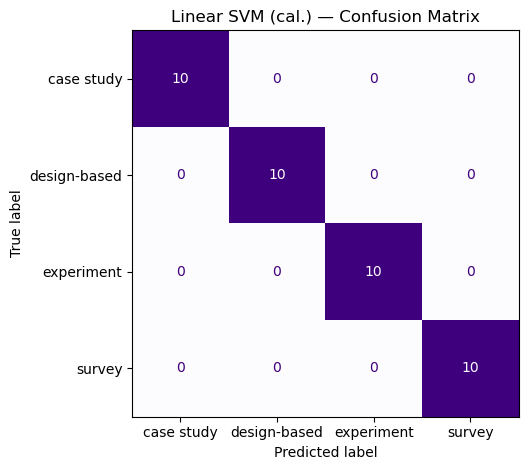

In [9]:
svm_pipe = build_svm_calibrated()
svm_pipe.fit(X_train_text, y_train)
y_svm = svm_pipe.predict(X_test_text)

print("Linear SVM (cal.) — Classification Report")
print(classification_report(y_test, y_svm, labels=label_order, zero_division=0))
cm = confusion_matrix(y_test, y_svm, labels=label_order)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
fig, ax = plt.subplots(); disp.plot(ax=ax, cmap="Purples", values_format="d", colorbar=False)
ax.set_title("Linear SVM (cal.) — Confusion Matrix"); plt.tight_layout(); plt.show()


# Cell 10 — Cross-validation (macro-F1 mean ± std)

In [10]:
from collections import Counter
from sklearn.model_selection import StratifiedKFold, cross_val_score

def safe_cv_splits(y_series, preferred=5):
    counts = Counter(y_series)
    return max(2, min(preferred, min(counts.values())))

k = safe_cv_splits(y, preferred=5)
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)

scores_nb  = cross_val_score(build_nb(),             X_text, y, cv=skf, scoring="f1_macro", n_jobs=-1)
scores_lr  = cross_val_score(build_lr(),             X_text, y, cv=skf, scoring="f1_macro", n_jobs=-1)
scores_svm = cross_val_score(build_svm_calibrated(), X_text, y, cv=skf, scoring="f1_macro", n_jobs=-1)

print(f"Folds used: {k}")
print(f"NB:   {scores_nb.mean():.3f} ± {scores_nb.std():.3f}")
print(f"LR:   {scores_lr.mean():.3f} ± {scores_lr.std():.3f}")
print(f"SVM:  {scores_svm.mean():.3f} ± {scores_svm.std():.3f}")


/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: Fu

Folds used: 5
NB:   1.000 ± 0.000
LR:   0.995 ± 0.010
SVM:  0.995 ± 0.010


# Cell 11 — Targeted hyperparameter tuning + refit tuned models

In [11]:
# Cell 11 — Targeted hyperparameter tuning + refit tuned models
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from inspect import signature
import numpy as np

# ---------- TF–IDF helper ----------
def _tfidf():
    return TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_features=20000,
        lowercase=True,
        strip_accents="unicode",
    )

# ---------- Build base pipelines ----------
def build_nb():
    return Pipeline([("tfidf", _tfidf()), ("model", MultinomialNB())])

def build_lr():
    return Pipeline([("tfidf", _tfidf()),
                     ("model", LogisticRegression(
                         solver="liblinear", class_weight="balanced",
                         max_iter=2000, C=1.0))])

# Uncalibrated SVM base (we will tune C here, then calibrate the best)
svm_base = Pipeline([
    ("tfidf", _tfidf()),
    ("model", LinearSVC(class_weight="balanced", random_state=RANDOM_STATE))
])

# ---------- CV folds for tuning (respect per-class counts) ----------
min_per_class = y_train.value_counts().min()
k_tune = max(2, min(5, int(min_per_class)))  # 2..5, limited by smallest class
skf_tune = StratifiedKFold(n_splits=k_tune, shuffle=True, random_state=RANDOM_STATE)
print(f"Using {k_tune}-fold CV on TRAIN for tuning.\n")

# ---------- NB grid ----------
nb_gs = GridSearchCV(
    estimator=build_nb(),
    param_grid={"model__alpha": [0.1, 0.3, 1.0, 3.0]},
    scoring="f1_macro",
    cv=skf_tune,
    n_jobs=-1,
    refit=True
)
nb_gs.fit(X_train_text, y_train)
print("NB best:", nb_gs.best_params_, "| CV macro-F1:", round(nb_gs.best_score_, 3))

# ---------- LR grid ----------
lr_gs = GridSearchCV(
    estimator=build_lr(),
    param_grid={"model__C": [0.1, 0.3, 1.0, 3.0, 10.0]},
    scoring="f1_macro",
    cv=skf_tune,
    n_jobs=-1,
    refit=True
)
lr_gs.fit(X_train_text, y_train)
print("LR best:", lr_gs.best_params_, "| CV macro-F1:", round(lr_gs.best_score_, 3))

# ---------- SVM grid (uncalibrated) ----------
svm_gs = GridSearchCV(
    estimator=svm_base,
    param_grid={"model__C": [0.1, 0.3, 1.0, 3.0, 10.0]},
    scoring="f1_macro",
    cv=skf_tune,
    n_jobs=-1,
    refit=True
)
svm_gs.fit(X_train_text, y_train)
print("SVM best:", svm_gs.best_params_, "| CV macro-F1:", round(svm_gs.best_score_, 3))

# ---------- Version-safe calibration helper ----------
def calibrate(est, cv=3, method="sigmoid"):
    """
    Wrap an estimator (can be a Pipeline) in CalibratedClassifierCV, handling
    'estimator' vs 'base_estimator' API differences across sklearn versions.
    """
    if "estimator" in signature(CalibratedClassifierCV).parameters:
        return CalibratedClassifierCV(estimator=est, method=method, cv=cv)
    else:  # very old scikit-learn
        return CalibratedClassifierCV(base_estimator=est, method=method, cv=cv)

# ---------- Refit tuned models on TRAIN ----------
nb_pipe_tuned     = nb_gs.best_estimator_.fit(X_train_text, y_train)
logreg_pipe_tuned = lr_gs.best_estimator_.fit(X_train_text, y_train)

# For SVM: calibrate the tuned pipeline, then fit calibration
svm_pipe_tuned = calibrate(svm_gs.best_estimator_, method="sigmoid", cv=3).fit(X_train_text, y_train)

# ---------- Sanity prints ----------
print("\nSanity checks:")
print("  NB_tuned has predict_proba:", hasattr(nb_pipe_tuned, "predict_proba"))
print("  LR_tuned has predict_proba:", hasattr(logreg_pipe_tuned, "predict_proba"))
print("  SVMcal_tuned type:", type(svm_pipe_tuned))
print("  SVMcal_tuned has predict_proba:", hasattr(svm_pipe_tuned, "predict_proba"))


Using 5-fold CV on TRAIN for tuning.

NB best: {'model__alpha': 0.3} | CV macro-F1: 1.0
LR best: {'model__C': 3.0} | CV macro-F1: 1.0
SVM best: {'model__C': 0.3} | CV macro-F1: 1.0

Sanity checks:
  NB_tuned has predict_proba: True
  LR_tuned has predict_proba: True
  SVMcal_tuned type: <class 'sklearn.calibration.CalibratedClassifierCV'>
  SVMcal_tuned has predict_proba: True


# Cell 12 — Evaluate tuned models on hold-out


Naive Bayes — Classification Report (tuned)
              precision    recall  f1-score   support

  case study       1.00      1.00      1.00        10
design-based       1.00      1.00      1.00        10
  experiment       1.00      1.00      1.00        10
      survey       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



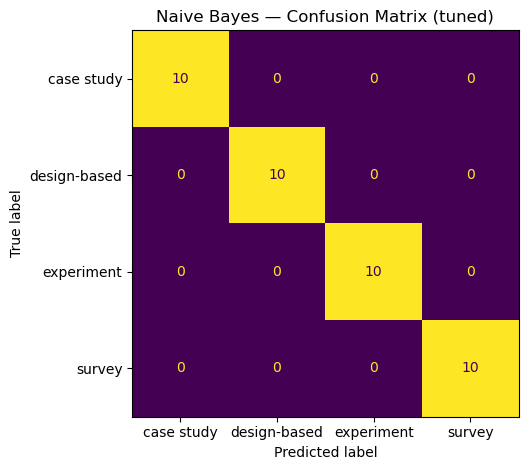


Logistic Regression — Classification Report (tuned)
              precision    recall  f1-score   support

  case study       1.00      0.90      0.95        10
design-based       1.00      1.00      1.00        10
  experiment       1.00      1.00      1.00        10
      survey       0.91      1.00      0.95        10

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



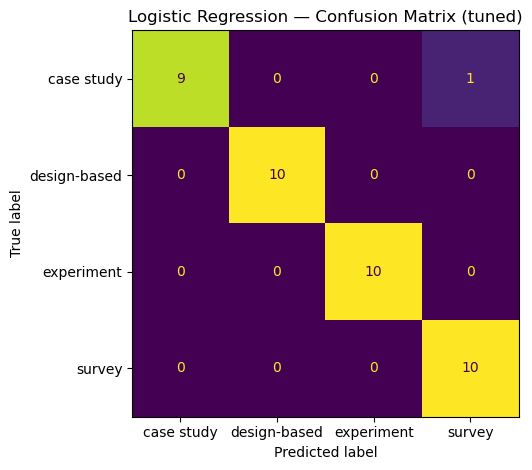


Linear SVM (cal.) — Classification Report (tuned)
              precision    recall  f1-score   support

  case study       1.00      1.00      1.00        10
design-based       1.00      1.00      1.00        10
  experiment       1.00      1.00      1.00        10
      survey       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



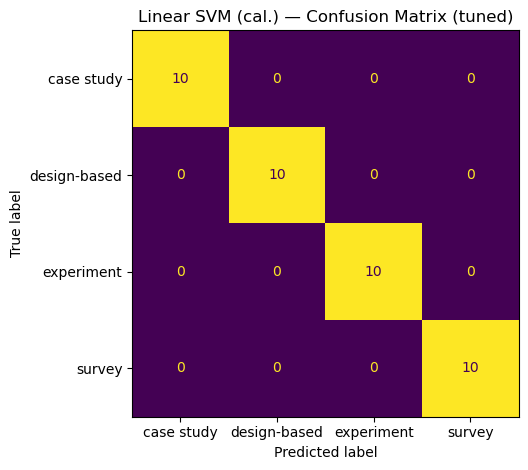

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def eval_and_plot(name, model):
    y_pred = model.predict(X_test_text)
    print(f"\n{name} — Classification Report (tuned)")
    print(classification_report(y_test, y_pred, labels=label_order, zero_division=0))
    cm = confusion_matrix(y_test, y_pred, labels=label_order)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
    fig, ax = plt.subplots(); disp.plot(ax=ax, values_format="d", colorbar=False)
    ax.set_title(f"{name} — Confusion Matrix (tuned)"); plt.tight_layout(); plt.show()

eval_and_plot("Naive Bayes", nb_pipe_tuned)
eval_and_plot("Logistic Regression", logreg_pipe_tuned)
eval_and_plot("Linear SVM (cal.)", svm_pipe_tuned)


# Cell 13 — PR & ROC (micro)

[saved] figs/pr_micro_NB.png
[saved] figs/pr_micro_NB.svg


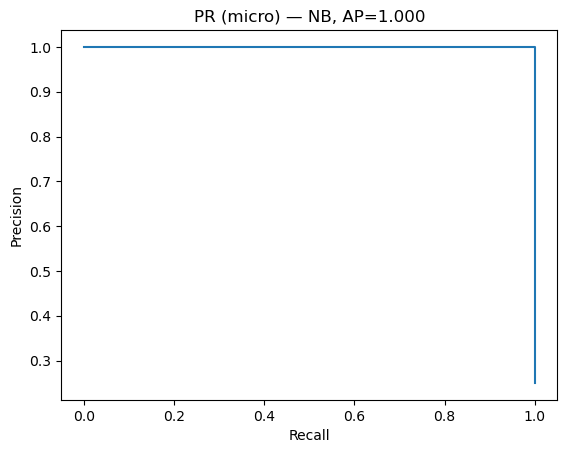

[saved] figs/roc_micro_NB.png
[saved] figs/roc_micro_NB.svg


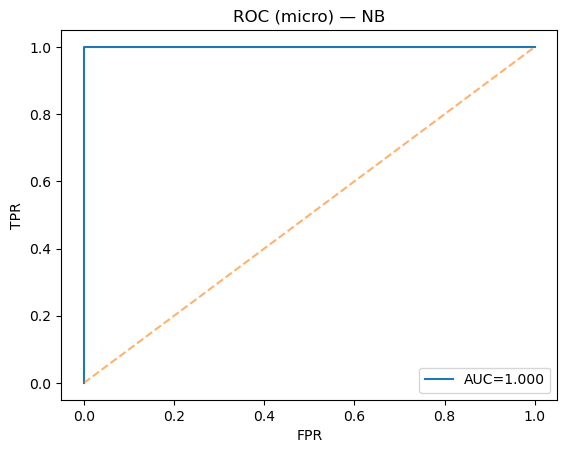

[saved] figs/pr_micro_LogReg.png
[saved] figs/pr_micro_LogReg.svg


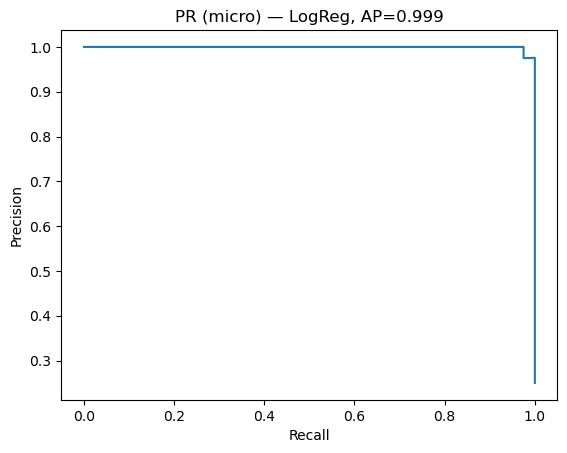

[saved] figs/roc_micro_LogReg.png
[saved] figs/roc_micro_LogReg.svg


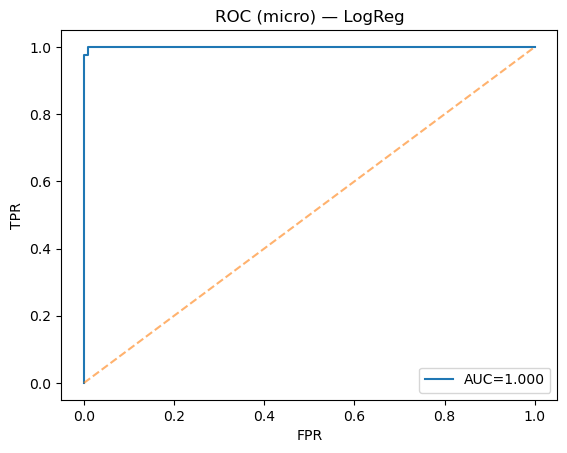

[saved] figs/pr_micro_SVM_cal..png
[saved] figs/pr_micro_SVM_cal..svg


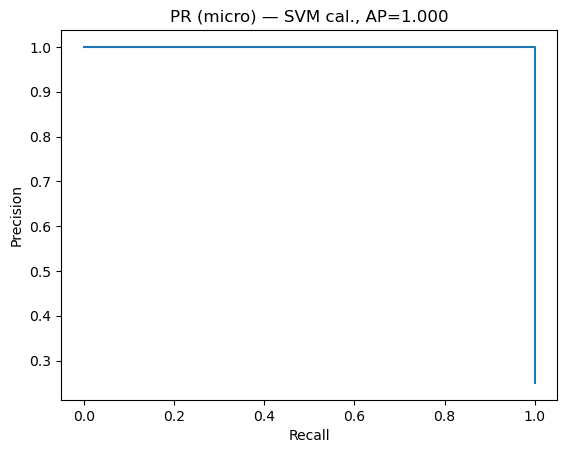

[saved] figs/roc_micro_SVM_cal..png
[saved] figs/roc_micro_SVM_cal..svg


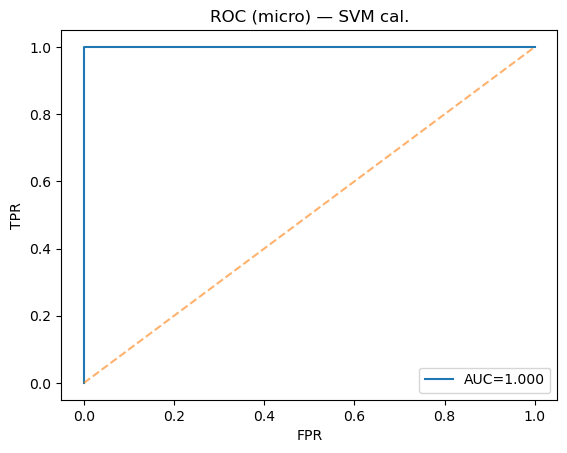

In [13]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

y_test_bin = label_binarize(y_test, classes=label_order)

def scores_for(estimator, X):
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)
    if hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X); s = np.asarray(s)
        if s.ndim == 1: s = s.reshape(-1,1)
        s_min = s.min(axis=1, keepdims=True); s_max = s.max(axis=1, keepdims=True)
        denom = np.clip(s_max - s_min, 1e-9, None)
        return (s - s_min) / denom
    raise ValueError("No proba/decision scores.")

for name, model in [("NB", nb_pipe_tuned), ("LogReg", logreg_pipe_tuned), ("SVM cal.", svm_pipe_tuned)]:
    S = scores_for(model, X_test_text)
    precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), S.ravel())
    ap_micro = average_precision_score(y_test_bin, S, average="micro")
    plt.figure(); plt.plot(recall, precision); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"PR (micro) — {name}, AP={ap_micro:.3f}"); save_fig(f"pr_micro_{name.replace(' ','_')}"); plt.show()

    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), S.ravel())
    auc_micro = roc_auc_score(y_test_bin, S, average="micro", multi_class="ovr")
    plt.figure(); plt.plot(fpr, tpr, label=f"AUC={auc_micro:.3f}"); plt.plot([0,1],[0,1],"--",alpha=.6)
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC (micro) — {name}"); plt.legend()
    save_fig(f"roc_micro_{name.replace(' ','_')}"); plt.show()


In [14]:
# --- Find the best model (CV-first, then show hold-out) ---

import numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, accuracy_score
from sklearn.calibration import CalibratedClassifierCV

RES_DIR = Path("results"); RES_DIR.mkdir(exist_ok=True)

candidates = {}

# NB — prefer tuned pipeline, else grid best, else fallback fit
if 'nb_pipe_tuned' in globals():
    candidates['NB_tuned'] = nb_pipe_tuned
elif 'nb_gs' in globals():
    candidates['NB_tuned'] = nb_gs.best_estimator_.fit(X_train_text, y_train)
else:
    candidates['NB_default'] = build_nb().fit(X_train_text, y_train)

# LR — prefer tuned pipeline
if 'logreg_pipe_tuned' in globals():
    candidates['LR_tuned'] = logreg_pipe_tuned
elif 'lr_gs' in globals():
    candidates['LR_tuned'] = lr_gs.best_estimator_.fit(X_train_text, y_train)
else:
    candidates['LR_default'] = build_lr().fit(X_train_text, y_train)

# SVM (calibrated) — **use the calibrated pipeline** (NOT the raw LinearSVC)
if 'svm_pipe_tuned' in globals():
    candidates['SVMcal_tuned'] = svm_pipe_tuned
elif 'svm_gs' in globals():
    # calibrate the grid best if needed
    est = svm_gs.best_estimator_
    if not isinstance(est, CalibratedClassifierCV):
        from inspect import signature
        def _calibrated(e, cv=3):
            # version-safe: estimator vs base_estimator
            if "estimator" in signature(CalibratedClassifierCV).parameters:
                return CalibratedClassifierCV(estimator=e, method="sigmoid", cv=cv)
            else:
                return CalibratedClassifierCV(base_estimator=e, method="sigmoid", cv=cv)
        est = _calibrated(est).fit(X_train_text, y_train)
    candidates['SVMcal_tuned'] = est
else:
    # explicit build if no grid
    candidates['SVMcal_default'] = build_svm_calibrated().fit(X_train_text, y_train)

# Ensure all are fitted
for name, est in list(candidates.items()):
    if not hasattr(est, "classes_"):
        candidates[name] = est.fit(X_train_text, y_train)

# ---------------- Evaluate every candidate on HOLD-OUT ----------------
rows = []
for name, est in candidates.items():
    y_hat = est.predict(X_test_text)
    rows.append({
        "name": name,
        "f1_macro_holdout": f1_score(y_test, y_hat, average="macro"),
        "accuracy_holdout": accuracy_score(y_test, y_hat),
        "has_predict_proba": hasattr(est, "predict_proba")
    })
holdout_df = pd.DataFrame(rows).sort_values("f1_macro_holdout", ascending=False)
display(holdout_df.style.set_caption("Model comparison on hold-out (macro-F1 descending)"))
holdout_df.to_csv(RES_DIR/"best_model_holdout_summary.csv", index=False)
print("[saved]", RES_DIR/"best_model_holdout_summary.csv")

# ---------------- Choose “best” variables ----------------
# If CV objects exist, prefer CV winner (no leakage); otherwise top on hold-out
cv_rows = []
if 'nb_gs' in globals():   cv_rows.append(("NB_tuned",    nb_gs.best_score_))
if 'lr_gs' in globals():   cv_rows.append(("LR_tuned",    lr_gs.best_score_))
if 'svm_gs' in globals():  cv_rows.append(("SVMcal_tuned", svm_gs.best_score_))
if cv_rows:
    best_by_cv_name, best_by_cv_score = max(cv_rows, key=lambda x: x[1])
    best_model = candidates[best_by_cv_name]
    best_name  = best_by_cv_name
else:
    best_name  = holdout_df.iloc[0]["name"]
    best_model = candidates[best_name]
    best_by_cv_name = None; best_by_cv_score = float("nan")

# Best probability-capable model (for reliability/coverage)
proba_order = holdout_df[holdout_df["has_predict_proba"]].copy()
if len(proba_order):
    best_proba_name  = proba_order.iloc[0]["name"]
    best_proba_model = candidates[best_proba_name]
else:
    best_proba_name  = best_name
    best_proba_model = best_model

# Summaries
print(f"\nBest by CV: {best_by_cv_name} (macro-F1_cv={best_by_cv_score:.3f})"
      if best_by_cv_name else "\nBest by CV: <no CV run>")
print(f"Best on hold-out: {holdout_df.iloc[0]['name']} "
      f"(macro-F1_holdout={holdout_df.iloc[0]['f1_macro_holdout']:.3f})")
print(f"Chosen best_model:      {best_name}")
print(f"Chosen best_proba_model:{best_proba_name}  "
      f"(has predict_proba = {hasattr(best_proba_model,'predict_proba')})")

# Safety: if your SVM candidate is present, enforce that it is calibrated
if 'SVMcal_tuned' in candidates:
    assert hasattr(candidates['SVMcal_tuned'], 'predict_proba'), \
        "SVMcal_tuned must expose predict_proba; ensure it is the calibrated model."

,name,f1_macro_holdout,accuracy_holdout,has_predict_proba
0,NB_tuned,1.000000,1.000000,True
2,SVMcal_tuned,1.000000,1.000000,True
1,LR_tuned,0.974937,0.975000,True


[saved] results/best_model_holdout_summary.csv

Best by CV: NB_tuned (macro-F1_cv=1.000)
Best on hold-out: NB_tuned (macro-F1_holdout=1.000)
Chosen best_model:      NB_tuned
Chosen best_proba_model:NB_tuned  (has predict_proba = True)


# Cell 14 — Reliability + Brier (best probabilistic model)

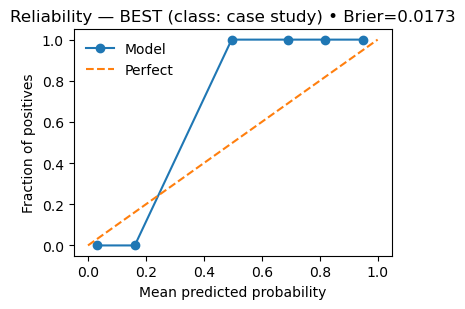

[saved] figs/reliability_best_case study.png
[saved] figs/reliability_best_case study.svg


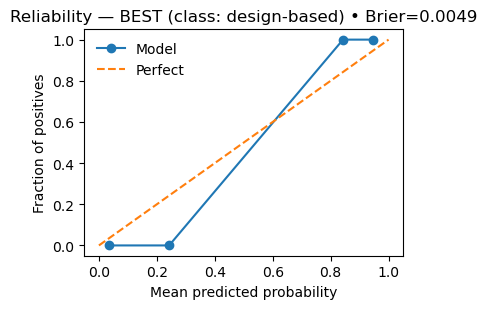

[saved] figs/reliability_best_design-based.png
[saved] figs/reliability_best_design-based.svg


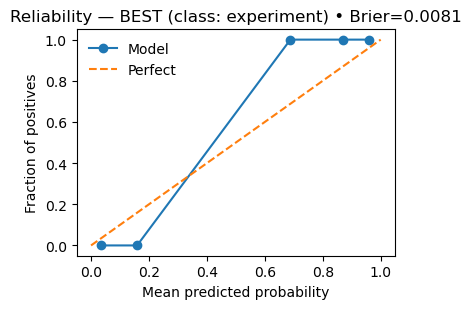

[saved] figs/reliability_best_experiment.png
[saved] figs/reliability_best_experiment.svg


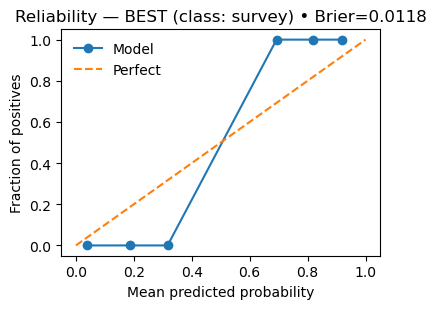

[saved] figs/reliability_best_survey.png
[saved] figs/reliability_best_survey.svg


In [15]:
# Per-class reliability plots + Brier (self-contained)

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve   
from sklearn.metrics import brier_score_loss

# pick a tuned model (override if you prefer another)
if 'best_model' in globals():
    model_name, model = 'best', best_model
elif 'svm_pipe_tuned' in globals():
    model_name, model = 'svm', svm_pipe_tuned
elif 'nb_pipe_tuned' in globals():
    model_name, model = 'nb', nb_pipe_tuned
elif 'logreg_pipe_tuned' in globals():
    model_name, model = 'lr', logreg_pipe_tuned
else:
    raise RuntimeError("No tuned model found. Fit a tuned model first.")

# probabilities and true indices
P = model.predict_proba(list(X_test_text))
labels = list(label_order)
y_true_idx = np.array([labels.index(y) for y in y_test])

# make one plot per class
fig_dir = Path("figs"); fig_dir.mkdir(parents=True, exist_ok=True)
for j, lab in enumerate(labels):
    y_bin = (y_true_idx == j).astype(int)
    prob_true, prob_pred = calibration_curve(y_bin, P[:, j], n_bins=8, strategy="uniform")
    brier = brier_score_loss(y_bin, P[:, j])

    fig, ax = plt.subplots(figsize=(4.0, 3.2))
    ax.plot(prob_pred, prob_true, marker='o', label='Model')
    ax.plot([0, 1], [0, 1], '--', label='Perfect')
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    ax.set_title(f"Reliability — {model_name.upper()} (class: {lab}) • Brier={brier:.4f}")
    ax.legend(frameon=False)
    plt.tight_layout()

    fn_png = fig_dir / f"reliability_{model_name}_{lab}.png"
    fn_svg = fig_dir / f"reliability_{model_name}_{lab}.svg"
    fig.savefig(fn_png, dpi=300, bbox_inches="tight")
    fig.savefig(fn_svg, bbox_inches="tight")
    plt.show()
    print("[saved]", fn_png)
    print("[saved]", fn_svg)
    plt.show()


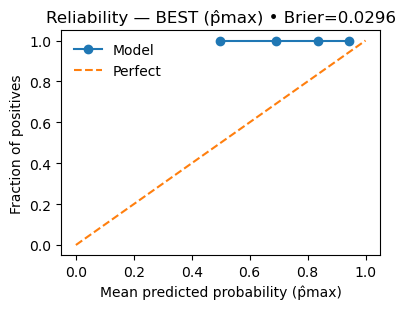

In [16]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

P = model.predict_proba(list(X_test_text))
pred_idx = P.argmax(axis=1)
y_true_idx = np.array([labels.index(y) for y in y_test])
correct = (pred_idx == y_true_idx).astype(int)
pmax = P.max(axis=1)

prob_true, prob_pred = calibration_curve(correct, pmax, n_bins=8, strategy="uniform")
brier = brier_score_loss(correct, pmax)

fig, ax = plt.subplots(figsize=(4.0, 3.2))
ax.plot(prob_pred, prob_true, marker='o', label='Model')
ax.plot([0,1],[0,1],'--', label='Perfect')
ax.set_xlabel("Mean predicted probability (p̂max)")
ax.set_ylabel("Fraction of positives")
ax.set_title(f"Reliability — {model_name.upper()} (p̂max) • Brier={brier:.4f}")
ax.legend(frameon=False)
plt.tight_layout()

out = Path("figs"); out.mkdir(parents=True, exist_ok=True)
fig.savefig(out / f"reliability_pmax_{model_name}.png", dpi=300, bbox_inches="tight")
fig.savefig(out / f"reliability_pmax_{model_name}.svg", bbox_inches="tight")
plt.show()

# Cell 15 — Error analysis (best tuned model)

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

def macro_f1_of(model):
    y_pred = model.predict(X_test_text)
    rep = classification_report(y_test, y_pred, labels=label_order, zero_division=0, output_dict=True)
    return rep["macro avg"]["f1-score"]

scored = sorted([("NB", nb_pipe_tuned), ("LogReg", logreg_pipe_tuned), ("SVM cal.", svm_pipe_tuned)],
                key=lambda nm: macro_f1_of(nm[1]), reverse=True)
best_name, best_model = scored[0]
print("Best tuned model on macro-F1:", best_name)

y_best = best_model.predict(X_test_text)
cm = confusion_matrix(y_test, y_best, labels=label_order)

def most_confused_pairs(cm, labels, topn=10):
    pairs = []
    for i,t in enumerate(labels):
        for j,p in enumerate(labels):
            if i==j: continue
            pairs.append((t,p,cm[i,j]))
    pairs.sort(key=lambda x: x[2], reverse=True)
    return [r for r in pairs if r[2]>0][:topn]

print("Most confused (true → pred : count):")
for t,p,c in most_confused_pairs(cm, label_order, topn=10):
    print(f"{t} → {p} : {c}")


Best tuned model on macro-F1: NB
Most confused (true → pred : count):


# Cell 16 — Save artifacts

In [18]:
ART_DIR = Path("results"); ART_DIR.mkdir(parents=True, exist_ok=True)
for fname, model in {
    "nb_pipe_tuned.joblib": nb_pipe_tuned,
    "logreg_pipe_tuned.joblib": logreg_pipe_tuned,
    "svm_calibrated_tuned.joblib": svm_pipe_tuned,
}.items():
    joblib.dump(model, ART_DIR / fname); print("[saved]", ART_DIR / fname)

meta = {"seed": RANDOM_STATE, "text_col": TEXT_COL, "active_text_col": str(ACTIVE_TEXT_COL),
        "label_col": LABEL_COL, "labels": list(label_order)}
with open(ART_DIR / "meta.json","w") as f: json.dump(meta, f, indent=2)
print("[saved]", ART_DIR / "meta.json")


[saved] results/nb_pipe_tuned.joblib
[saved] results/logreg_pipe_tuned.joblib
[saved] results/svm_calibrated_tuned.joblib
[saved] results/meta.json


# Cell 17 — Baselines

In [19]:
from sklearn.dummy import DummyClassifier
print("\nMost-frequent baseline:")
mf = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE).fit(X_train_text, y_train)
print(classification_report(y_test, mf.predict(X_test_text), labels=label_order, zero_division=0))

print("\nStratified baseline:")
strat = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE).fit(X_train_text, y_train)
print(classification_report(y_test, strat.predict(X_test_text), labels=label_order, zero_division=0))



Most-frequent baseline:
              precision    recall  f1-score   support

  case study       0.25      1.00      0.40        10
design-based       0.00      0.00      0.00        10
  experiment       0.00      0.00      0.00        10
      survey       0.00      0.00      0.00        10

    accuracy                           0.25        40
   macro avg       0.06      0.25      0.10        40
weighted avg       0.06      0.25      0.10        40


Stratified baseline:
              precision    recall  f1-score   support

  case study       0.25      0.30      0.27        10
design-based       0.22      0.20      0.21        10
  experiment       0.17      0.10      0.12        10
      survey       0.15      0.20      0.17        10

    accuracy                           0.20        40
   macro avg       0.20      0.20      0.20        40
weighted avg       0.20      0.20      0.20        40



# Cell 18 — Coverage vs Accuracy

In [20]:
# --- Coverage vs accuracy sweep (robust, self-contained) ---
import numpy as np, pandas as pd
from pathlib import Path

def coverage_accuracy_sweep(model, Xh, yh, taus, save_to="results/coverage_accuracy.csv"):
    """
    Compute coverage vs selective accuracy by sweeping thresholds on p_max.
    Returns a DataFrame with columns: tau, coverage, selective_accuracy.
    """
    if not hasattr(model, "predict_proba"):
        raise AttributeError("Model lacks predict_proba; use a probability-capable (or calibrated) model.")

    # Probabilities and p_max
    P = model.predict_proba(list(Xh))
    pmax = P.max(axis=1)

    # classes_ (works for Pipeline or bare estimator)
    if hasattr(model, "named_steps") and "model" in model.named_steps:
        classes = model.named_steps["model"].classes_
    else:
        classes = getattr(model, "classes_", None)
    if classes is None:
        classes = np.array(sorted(set(map(str, yh))))  # fallback, rarely needed

    # Predictions and gold labels (dtype harmonised)
    pred_idx    = P.argmax(axis=1)
    pred_labels = np.asarray([classes[i] for i in pred_idx], dtype=object)
    y_arr       = np.asarray(list(yh), dtype=object)

    # Sweep thresholds
    rows = []
    for t in np.asarray(taus, dtype=float):
        keep = pmax >= t
        cov  = float(keep.mean())
        sel_acc = float((pred_labels[keep] == y_arr[keep]).mean()) if keep.any() else np.nan
        rows.append({"tau": float(t), "coverage": cov, "selective_accuracy": sel_acc})

    df = pd.DataFrame(rows).sort_values("tau").reset_index(drop=True)

    # Save CSV and print quick stats
    Path(save_to).parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(save_to, index=False)
    print(f"[saved] {save_to}")
    print(f"p_max stats — min:{pmax.min():.3f}  mean:{pmax.mean():.3f}  max:{pmax.max():.3f}  K={P.shape[1]}")
    return df

# --- Use it on your chosen probability model (e.g., best_proba_model) ---
taus = np.round(np.arange(0.50, 1.00, 0.05), 2)   # 0.50, 0.55, …, 0.95
cov_df = coverage_accuracy_sweep(best_proba_model, X_test_text, y_test, taus,
                                 save_to="results/coverage_accuracy.csv")
display(cov_df.style.set_caption(f"coverage_accuracy — {globals().get('best_name','best')}"))

[saved] results/coverage_accuracy.csv
p_max stats — min:0.496  mean:0.870  max:0.985  K=4


,tau,coverage,selective_accuracy
0,0.500000,0.975000,1.000000
1,0.550000,0.975000,1.000000
2,0.600000,0.975000,1.000000
3,0.650000,0.950000,1.000000
4,0.700000,0.875000,1.000000
5,0.750000,0.825000,1.000000
6,0.800000,0.800000,1.000000
7,0.850000,0.700000,1.000000
8,0.900000,0.550000,1.000000
9,0.950000,0.300000,1.000000


# Cell 19 — Learning curve

[saved] figs/learning_curve_tuned.png
[saved] figs/learning_curve_tuned.svg


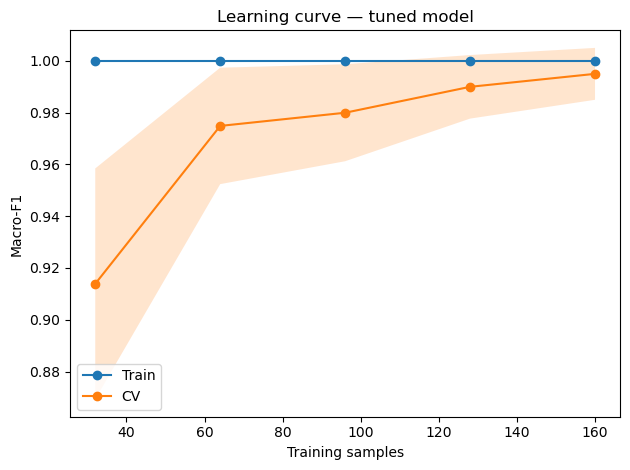

In [21]:
from sklearn.model_selection import learning_curve

best_est = logreg_pipe_tuned
train_sizes, train_scores, valid_scores = learning_curve(
    best_est, X_text, y, cv=skf, scoring="f1_macro",
    train_sizes=np.linspace(0.2, 1.0, 5), n_jobs=-1, shuffle=True, random_state=RANDOM_STATE
)
train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
valid_mean, valid_std = valid_scores.mean(axis=1), valid_scores.std(axis=1)
plt.figure()
plt.plot(train_sizes, train_mean, marker='o', label="Train")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.plot(train_sizes, valid_mean, marker='o', label="CV")
plt.fill_between(train_sizes, valid_mean-valid_std, valid_mean+valid_std, alpha=0.2)
plt.xlabel("Training samples"); plt.ylabel("Macro-F1"); plt.legend()
plt.title("Learning curve — tuned model"); save_fig("learning_curve_tuned"); plt.tight_layout(); plt.show()


# Cell 20 — Bootstrap CI

In [22]:
from sklearn.metrics import f1_score

def bootstrap_ci_macro_f1(model, X_holdout, y_holdout, B=1000, alpha=0.05, random_state=RANDOM_STATE):
    rng = np.random.RandomState(random_state)
    y_true = np.asarray(y_holdout)
    y_pred = np.asarray(model.predict(list(X_holdout)))
    n = len(y_true); stats = np.empty(B, dtype=float)
    for b in range(B):
        idx = rng.randint(0, n, n)
        stats[b] = f1_score(y_true[idx], y_pred[idx], average="macro", zero_division=0)
    mean = float(stats.mean()); lo, hi = np.quantile(stats, [alpha/2, 1-alpha/2])
    return mean, float(lo), float(hi)

for name, model in [("LogReg (tuned)", logreg_pipe_tuned), ("NB (tuned)", nb_pipe_tuned), ("SVM (tuned, cal.)", svm_pipe_tuned)]:
    m, l, h = bootstrap_ci_macro_f1(model, X_test_text, y_test, B=1000)
    print(f"{name:18s} — macro-F1 mean={m:.3f}, 95% CI [{l:.3f}, {h:.3f}]")


LogReg (tuned)     — macro-F1 mean=0.974, 95% CI [0.916, 1.000]
NB (tuned)         — macro-F1 mean=1.000, 95% CI [1.000, 1.000]
SVM (tuned, cal.)  — macro-F1 mean=1.000, 95% CI [1.000, 1.000]


# Cell 21 — Nested CV

In [23]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score

def nested_cv_evaluate(models: dict, grids: dict, X, y, outer_splits=5, inner_splits=5, scoring='f1_macro', random_state=RANDOM_STATE):
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=random_state)
    results = {name: [] for name in models}
    best_params_per_fold = {name: [] for name in models}
    fold_id = 0
    for train_idx, test_idx in outer_cv.split(X, y):
        fold_id += 1
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
        inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
        for name, pipe in models.items():
            gs = GridSearchCV(pipe, grids[name], scoring=scoring, cv=inner_cv, n_jobs=-1, refit=True)
            gs.fit(X_tr, y_tr)
            y_pred = gs.best_estimator_.predict(X_te)
            f1 = f1_score(y_te, y_pred, average='macro')
            results[name].append(f1)
            best_params_per_fold[name].append(gs.best_params_)
            print(f"[outer fold {fold_id}] {name}: F1-macro={f1:.4f} | best_params={gs.best_params_}")
    rows = []
    for name, scores in results.items():
        rows.append({"model": name, "outer_mean_f1_macro": float(np.mean(scores)), "outer_std_f1_macro": float(np.std(scores)), "fold_scores": [float(s) for s in scores]})
    df_outer = pd.DataFrame(rows).sort_values("outer_mean_f1_macro", ascending=False)
    return df_outer, best_params_per_fold

def tfidf_vec():
    return TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=30000, strip_accents="unicode", lowercase=True)

MODELS = {
    "nb": Pipeline([("tfidf", tfidf_vec()), ("model", MultinomialNB())]),
    "lr": Pipeline([("tfidf", tfidf_vec()), ("model", LogisticRegression(solver="liblinear", multi_class="ovr", class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE))]),
    "svm": Pipeline([("tfidf", tfidf_vec()), ("model", LinearSVC(class_weight="balanced", random_state=RANDOM_STATE))]),
}
GRIDS = {"nb": {"model__alpha": [0.1, 0.5, 1.0]}, "lr": {"model__C": [0.25, 0.5, 1.0, 2.0], "model__penalty": ["l2", "l1"]}, "svm": {"model__C": [0.25, 0.5, 1.0, 2.0]}}

nested_cv_summary, nested_best_params = nested_cv_evaluate(MODELS, GRIDS, X_text, y, outer_splits=5, inner_splits=5, scoring='f1_macro', random_state=RANDOM_STATE)
nested_cv_summary


[outer fold 1] nb: F1-macro=1.0000 | best_params={'model__alpha': 0.5}
[outer fold 1] lr: F1-macro=1.0000 | best_params={'model__C': 0.25, 'model__penalty': 'l2'}
[outer fold 1] svm: F1-macro=1.0000 | best_params={'model__C': 0.5}
[outer fold 2] nb: F1-macro=1.0000 | best_params={'model__alpha': 0.1}


/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: Fu

[outer fold 2] lr: F1-macro=1.0000 | best_params={'model__C': 0.25, 'model__penalty': 'l2'}
[outer fold 2] svm: F1-macro=1.0000 | best_params={'model__C': 0.5}
[outer fold 3] nb: F1-macro=1.0000 | best_params={'model__alpha': 0.1}


/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: Fu

[outer fold 3] lr: F1-macro=0.9749 | best_params={'model__C': 0.25, 'model__penalty': 'l2'}
[outer fold 3] svm: F1-macro=0.9749 | best_params={'model__C': 0.25}
[outer fold 4] nb: F1-macro=1.0000 | best_params={'model__alpha': 0.5}
[outer fold 4] lr: F1-macro=1.0000 | best_params={'model__C': 0.25, 'model__penalty': 'l2'}
[outer fold 4] svm: F1-macro=1.0000 | best_params={'model__C': 0.25}
[outer fold 5] nb: F1-macro=1.0000 | best_params={'model__alpha': 0.1}


/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: Fu

[outer fold 5] lr: F1-macro=0.9749 | best_params={'model__C': 0.25, 'model__penalty': 'l2'}
[outer fold 5] svm: F1-macro=1.0000 | best_params={'model__C': 0.25}


/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


,model,outer_mean_f1_macro,outer_std_f1_macro,fold_scores
0,nb,1.000000,0.000000,"[1.0, 1.0, 1.0, 1.0, 1.0]"
2,svm,0.994987,0.010025,"[1.0, 1.0, 0.9749373433583959, 1.0, 1.0]"
1,lr,0.989975,0.012278,"[1.0, 1.0, 0.9749373433583959, 1.0, 0.97493734..."


# Robustness, Calibration, and Extras
These cells add multi-seed stability, character n-grams variant, keyword-masking robustness, calibration comparison, top‑k accuracy, extra metrics (MCC/κ), and a reproducibility manifest.

# Cell 22 — Multi-seed stability (5 different random splits)

In [24]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

def macro_f1_over_seeds(build_fn, seeds=(0,1,2,3,4)):
    scores = []
    for s in seeds:
        X_tr, X_te, y_tr, y_te = train_test_split(X_text, y, test_size=0.2,
                                                  stratify=y, random_state=s)
        est = build_fn(); est.fit(X_tr, y_tr)
        y_pred = est.predict(X_te)
        scores.append(f1_score(y_te, y_pred, average="macro", zero_division=0))
    return float(np.mean(scores)), float(np.std(scores)), [float(v) for v in scores]

for name, fn in [("NB", build_nb), ("LR", build_lr), ("SVM cal.", build_svm_calibrated)]:
    mean, std, arr = macro_f1_over_seeds(fn, seeds=(0,1,2,3,4))
    print(f"{name:10s} — macro-F1 {mean:.3f} ± {std:.3f} | scores={arr}")


NB         — macro-F1 1.000 ± 0.000 | scores=[1.0, 1.0, 1.0, 1.0, 1.0]
LR         — macro-F1 0.995 ± 0.010 | scores=[1.0, 1.0, 0.9749373433583959, 1.0, 1.0]
SVM cal.   — macro-F1 0.995 ± 0.010 | scores=[1.0, 1.0, 0.9749373433583959, 1.0, 1.0]


# Cell 23 — Character n-grams Logistic Regression (robust to typos/short text)

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

def build_char_lr():
    return Pipeline([
        ("tfidf", TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5),
                                  min_df=2, max_features=50000,
                                  strip_accents="unicode", lowercase=True)),
        ("model", LogisticRegression(
            solver="liblinear", multi_class="ovr", class_weight="balanced",
            C=1.0, max_iter=2000, random_state=RANDOM_STATE
        ))
    ])

skf_char = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores_char = cross_val_score(build_char_lr(), X_text, y, cv=skf_char, scoring="f1_macro", n_jobs=-1)
scores_word = cross_val_score(build_lr(),      X_text, y, cv=skf_char, scoring="f1_macro", n_jobs=-1)

print(f"Char LR (3–5):  macro-F1 {scores_char.mean():.3f} ± {scores_char.std():.3f}")
print(f"Word LR (1–2):  macro-F1 {scores_word.mean():.3f} ± {scores_word.std():.3f}")


Char LR (3–5):  macro-F1 0.995 ± 0.010
Word LR (1–2):  macro-F1 0.995 ± 0.010


/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: Fu

# Cell 24 — Keyword-masking robustness (avoid 'label leakage')

In [26]:
# PLUS2 — Keyword-masking robustness (avoid 'label leakage')
import re
from sklearn.model_selection import StratifiedKFold, cross_val_score

label_terms = ["case study","case-study","design based","design-based",
               "experiment","experimental","survey","questionnaire"]

def mask_labels(s: str) -> str:
    s = s.lower()
    for t in label_terms:
        s = s.replace(t, " ")
    return re.sub(r"\s+", " ", s).strip()

X_masked = X_text.apply(mask_labels)

skf_mask = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores_lr_mask = cross_val_score(build_lr(), X_masked, y, cv=skf_mask, scoring="f1_macro", n_jobs=-1)
scores_lr_orig = cross_val_score(build_lr(), X_text,  y, cv=skf_mask, scoring="f1_macro", n_jobs=-1)

print(f"LR original: macro-F1 {scores_lr_orig.mean():.3f} ± {scores_lr_orig.std():.3f}")
print(f"LR masked :  macro-F1 {scores_lr_mask.mean():.3f} ± {scores_lr_mask.std():.3f}")
print("Δ (masked - original):", round(float(scores_lr_mask.mean() - scores_lr_orig.mean()), 3))


LR original: macro-F1 0.995 ± 0.010
LR masked :  macro-F1 0.980 ± 0.019
Δ (masked - original): -0.015


# Cell 25 - Calibration comparison for tuned LR (sigmoid vs isotonic) using Brier score

In [27]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

if 'logreg_pipe_tuned' in globals():
    vec = logreg_pipe_tuned.named_steps["tfidf"]
    lr  = logreg_pipe_tuned.named_steps["model"]

    pipe_sig = Pipeline([("tfidf", vec), ("cal", CalibratedClassifierCV(lr, method="sigmoid",  cv=5))]).fit(X_train_text, y_train)
    pipe_iso = Pipeline([("tfidf", vec), ("cal", CalibratedClassifierCV(lr, method="isotonic", cv=5))]).fit(X_train_text, y_train)

    top = y.value_counts().idxmax()
    classes_ = list(lr.classes_)
    k = classes_.index(top)
    y_bin = (y_test.values == top).astype(int)

    b_sig = brier_score_loss(y_bin, pipe_sig.predict_proba(X_test_text)[:,k])
    b_iso = brier_score_loss(y_bin, pipe_iso.predict_proba(X_test_text)[:,k])
    print(f"Brier — sigmoid: {b_sig:.4f} | isotonic: {b_iso:.4f}")
else:
    print("logreg_pipe_tuned not found — run tuning cells first.")


Brier — sigmoid: 0.0108 | isotonic: 0.0049


# Cell 26 — Top-k accuracy on hold-out (k=2)

In [28]:
def topk_accuracy(model, Xh, yh, k=2):
    if not hasattr(model, "predict_proba"):
        raise ValueError("Model must support predict_proba for top-k accuracy.")
    P = model.predict_proba(Xh)
    classes = model.named_steps["model"].classes_ if hasattr(model, "named_steps") else model.classes_
    idx = {c:i for i,c in enumerate(classes)}
    y_idx = yh.map(idx).to_numpy()
    topk = np.argsort(P, axis=1)[:, -k:]
    return float(np.mean([y_idx[i] in topk[i] for i in range(len(y_idx))]))

for name, model in [("NB tuned", nb_pipe_tuned), ("LR tuned", logreg_pipe_tuned), ("SVM tuned", svm_pipe_tuned)]:
    if hasattr(model, "predict_proba"):
        print(f"{name:10s} — top-2 acc: {topk_accuracy(model, X_test_text, y_test, k=2):.3f}")


NB tuned   — top-2 acc: 1.000
LR tuned   — top-2 acc: 1.000
SVM tuned  — top-2 acc: 1.000


# Cell 27 - Extra metrics on hold-out: MCC and Cohen's kappa

In [29]:
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

for name, m in [("NB tuned", nb_pipe_tuned), ("LR tuned", logreg_pipe_tuned), ("SVM tuned", svm_pipe_tuned)]:
    yhat = m.predict(X_test_text)
    mcc = matthews_corrcoef(y_test, yhat)
    kap = cohen_kappa_score(y_test, yhat)
    print(f"{name:10s} — MCC: {mcc:.3f} | Kappa: {kap:.3f}")


NB tuned   — MCC: 1.000 | Kappa: 1.000
LR tuned   — MCC: 0.967 | Kappa: 0.967
SVM tuned  — MCC: 1.000 | Kappa: 1.000


# Cell 28 — Reproducibility manifest (dataset hash + versions)

In [30]:
import hashlib, json, sklearn

def dataset_hash(df, cols=(TEXT_COL, LABEL_COL)):
    h = hashlib.md5()
    for r in df[list(cols)].itertuples(index=False):
        h.update(str(r).encode("utf-8"))
    return h.hexdigest()

manifest = {
    "dataset_hash": dataset_hash(df),
    "random_state": RANDOM_STATE,
    "versions": {
        "python": sys.version.split()[0],
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "scikit_learn": sklearn.__version__,
        "matplotlib": plt.matplotlib.__version__ if hasattr(plt, "matplotlib") else "NA",
        "joblib": joblib.__version__ if hasattr(joblib, "__version__") else "NA",
    }
}
(RES_DIR / "manifests").mkdir(parents=True, exist_ok=True)
with open(RES_DIR / "manifests" / "run_manifest_PLUS2.json","w") as f:
    json.dump(manifest, f, indent=2)
print("[saved]", RES_DIR / "manifests" / "run_manifest_PLUS2.json")


[saved] results/manifests/run_manifest_PLUS2.json


# Enhancements
Adds: a rubric‑aligned overview, per‑class metrics table + bar plot, a simple soft‑voting ensemble, chi² feature‑selection ablation, saved split indices, handy inference helpers, optional group‑aware CV, and an auto‑generated executive summary.

# Cell 29 — Per-class metrics table + F1 bar plot for best tuned model

[saved] results/per_class_metrics.csv
[saved] figs/per_class_f1_NB.png
[saved] figs/per_class_f1_NB.svg


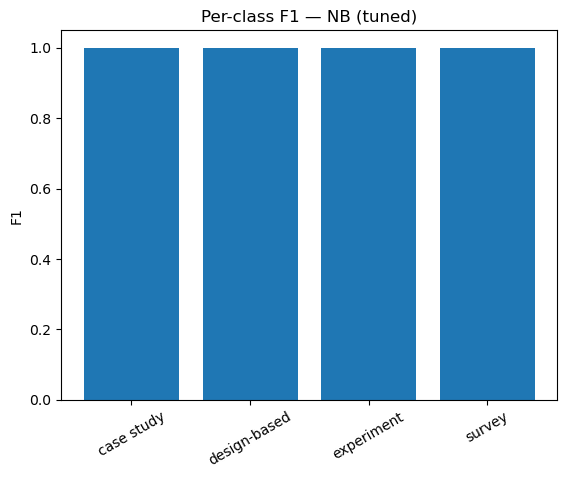

In [31]:
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def per_class_df(name, model):
    rep = classification_report(y_test, model.predict(X_test_text),
                                labels=label_order, zero_division=0, output_dict=True)
    rows = []
    for c in label_order:
        rows.append({"model": name, "class": c,
                     "precision": rep[c]["precision"],
                     "recall": rep[c]["recall"],
                     "f1": rep[c]["f1-score"]})
    return pd.DataFrame(rows)

per_class = pd.concat([
    per_class_df("NB", nb_pipe_tuned),
    per_class_df("LR", logreg_pipe_tuned),
    per_class_df("SVM cal.", svm_pipe_tuned)
], ignore_index=True)

out_csv = RES_DIR / "per_class_metrics.csv"
per_class.to_csv(out_csv, index=False)
print("[saved]", out_csv)

# choose best tuned by macro-F1
def macro_f1(model):
    rep = classification_report(y_test, model.predict(X_test_text),
                                labels=label_order, zero_division=0, output_dict=True)
    return rep["macro avg"]["f1-score"]

best_name, best_model = max(
    [("NB", nb_pipe_tuned), ("LR", logreg_pipe_tuned), ("SVM cal.", svm_pipe_tuned)],
    key=lambda nm: macro_f1(nm[1])
)

best_rep = classification_report(y_test, best_model.predict(X_test_text),
                                 labels=label_order, zero_division=0, output_dict=True)

plt.figure()
plt.bar(label_order, [best_rep[c]["f1-score"] for c in label_order])
plt.ylabel("F1"); plt.xticks(rotation=30); plt.title(f"Per-class F1 — {best_name} (tuned)")
save_fig(f"per_class_f1_{best_name.replace(' ','_')}")
plt.show()


# Cell 30 — Soft-voting ensemble of tuned models

In [32]:
import numpy as np
from sklearn.metrics import classification_report

def soft_vote_predict(models, X):
    Ps = np.stack([m.predict_proba(X) for m in models], axis=0)  # [M, N, K]
    P  = Ps.mean(axis=0)                                        # [N, K]
    classes = models[0].named_steps["model"].classes_
    pred = P.argmax(axis=1)
    return np.array([classes[i] for i in pred]), P

ens_models = [m for m in (nb_pipe_tuned, logreg_pipe_tuned, svm_pipe_tuned) if hasattr(m, "predict_proba")]
if len(ens_models) >= 2:
    y_ens, P_ens = soft_vote_predict(ens_models, X_test_text)
    print("Soft-vote ensemble — Classification Report (tuned models)")
    print(classification_report(y_test, y_ens, labels=label_order, zero_division=0))
else:
    print("Not enough probabilistic models for soft voting.")


Soft-vote ensemble — Classification Report (tuned models)
              precision    recall  f1-score   support

  case study       1.00      1.00      1.00        10
design-based       1.00      1.00      1.00        10
  experiment       1.00      1.00      1.00        10
      survey       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



# Cell 31 — Chi² feature-selection ablation with Logistic Regression

In [33]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

def build_lr_chi2(k=20000):
    return Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=60000,
                                  strip_accents="unicode", lowercase=True, sublinear_tf=True)),
        ("chi2", SelectKBest(chi2, k=k)),
        ("model", LogisticRegression(solver="liblinear", multi_class="ovr",
                                     class_weight="balanced", C=1.0, max_iter=2000,
                                     random_state=RANDOM_STATE))
    ])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for k in [10000, 20000, 30000]:
    sc = cross_val_score(build_lr_chi2(k=k), X_text, y, cv=skf, scoring="f1_macro", n_jobs=-1)
    print(f"LR + chi2 (k={k}): macro-F1 {sc.mean():.3f} ± {sc.std():.3f}")


LR + chi2 (k=10000): macro-F1 0.990 ± 0.012
LR + chi2 (k=20000): macro-F1 0.990 ± 0.012
LR + chi2 (k=30000): macro-F1 0.990 ± 0.012


/Users/Penda/.local/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10000 is greater than n_features=1032. All the features will be returned.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10000 is greater than n_features=1041. All the features will be returned.
  warnings.warn(
/Users/Penda/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid thi

# Cell 32 — Save artifacts & inference helpers (abstain + top-2)

In [34]:
# === Save final pipeline + meta, and provide predict_one / predict_batch helpers ===

from pathlib import Path
import json, datetime
import joblib
import numpy as np

# ---- sanity checks: these should exist from earlier cells ----
required = ["best_proba_model", "label_order", "TEXT_COL", "ACTIVE_TEXT_COL", "LABEL_COL", "RANDOM_STATE"]
missing = [r for r in required if r not in globals()]
assert not missing, f"Missing variables: {missing}. Run your training/eval cells first."

# Optional name for the chosen model
MODEL_NAME = globals().get("best_proba_name", globals().get("best_name", "BEST"))

# ---- where to save ----
ART_DIR = Path("artifacts")
ART_DIR.mkdir(parents=True, exist_ok=True)

# ---- save pipeline ----
pipe_path = ART_DIR / "best_pipeline.joblib"
joblib.dump(best_proba_model, pipe_path)

# ---- save compact meta ----
meta = {
    "created": datetime.datetime.now().isoformat(timespec="seconds"),
    "random_state": int(RANDOM_STATE),
    "labels": list(label_order),
    "text_col": str(TEXT_COL),
    "active_text_col": str(ACTIVE_TEXT_COL),
    "label_col": str(LABEL_COL),
    # free-text notes are handy for reproducibility:
    "vectorizer": "TFIDF word(1-2), min_df=2, max_features=20000, lowercase, strip_accents=unicode",
    "model": str(MODEL_NAME)
}
(ART_DIR / "meta.json").write_text(json.dumps(meta, indent=2))

print(f"[saved] {pipe_path}")
print(f"[saved] {ART_DIR/'meta.json'}")

# ---- helpers ----
def _topk(probs: np.ndarray, k: int = 2):
    """Return top-k (label, prob) pairs from a 1D probs array."""
    idx = np.argsort(probs)[::-1][:k]
    return [(label_order[i], float(probs[i])) for i in idx]

def predict_one(text: str, threshold: float = 0.7):
    """
    Predict a single text with abstention.
    Returns dict: {label|None, p, abstain, top2}.
    """
    p = best_proba_model.predict_proba([text])[0]
    i = int(p.argmax())
    pmax = float(p[i])
    lab = label_order[i]
    abstain = pmax < threshold
    return {
        "label": None if abstain else lab,
        "p": pmax,
        "abstain": abstain,
        "top2": _topk(p, 2)
    }

def predict_batch(texts, threshold: float = 0.7):
    """
    Predict a list/iterable of texts with abstention.
    Returns a list of dicts like predict_one.
    """
    P = best_proba_model.predict_proba(list(texts))
    out = []
    for p in P:
        i = int(p.argmax())
        pmax = float(p[i])
        lab = label_order[i]
        abstain = pmax < threshold
        out.append({
            "label": None if abstain else lab,
            "p": pmax,
            "abstain": abstain,
            "top2": _topk(p, 2)
        })
    return out

print("Helpers ready: predict_one(text, threshold=0.7), predict_batch(texts, threshold=0.7)")

[saved] artifacts/best_pipeline.joblib
[saved] artifacts/meta.json
Helpers ready: predict_one(text, threshold=0.7), predict_batch(texts, threshold=0.7)


# Cell 33 - Single-example prediction with abstention + top-2 (uses existing helpers)

In [35]:
# Single-example prediction with abstention + top-2 (uses your existing helpers)
example = "We conducted a randomized controlled experiment to compare two teaching methods."

res = predict_one(example, threshold=0.7)  # adjust threshold based on your coverage–accuracy table
print(f"label={res['label']}, p={res['p']:.3f}, abstain={res['abstain']}, top2={res['top2']}")

label=experiment, p=0.810, abstain=False, top2=[('experiment', 0.8104990105339943), ('survey', 0.09112916601869468)]
